In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
# initial condition
k0 = 10
s0 = 0.1
def u0_func(x):
    return (2*np.pi*s0**2)**(-1/4)*np.exp(-x**2/(4*s0**2) + 1j*k0*x)

# exact sol
def u_ex(x,t):
    fac = s0**(1/2)*(2*np.pi)**(-1/4)*np.exp(-(s0*k0)**2)
    aux1 = (s0**2 + 0.5*1j*t)**(-1/2)
    aux2 = (4*s0**4*k0**2 - x**2 + 4*1j*s0**2*k0*x)/(4*(s0**2 + 0.5*1j*t))
    return fac*aux1*np.exp(aux2)

# RHS of PDE in Fourier space, -0.5i*xi^2*uhat
def rhs(uhat_sep,t,xi):
    N2 = uhat_sep.size
    N = int(N2/2)
    uhat = uhat_sep[:N] + 1j*uhat_sep[N:]
    uhat_t = -0.5*1j*xi**2*uhat
    uhat_t_sep = np.concatenate((uhat_t.real,uhat_t.imag))
    return uhat_t_sep

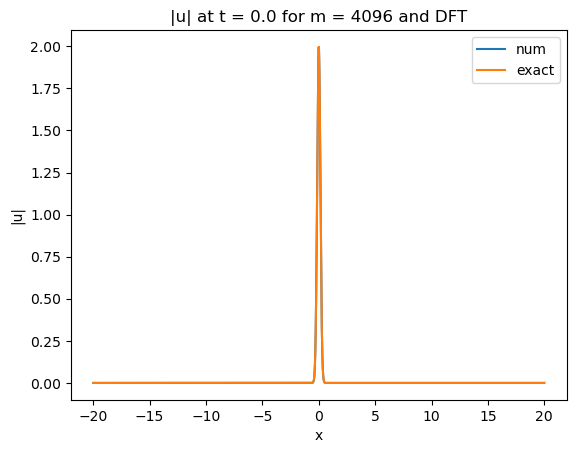

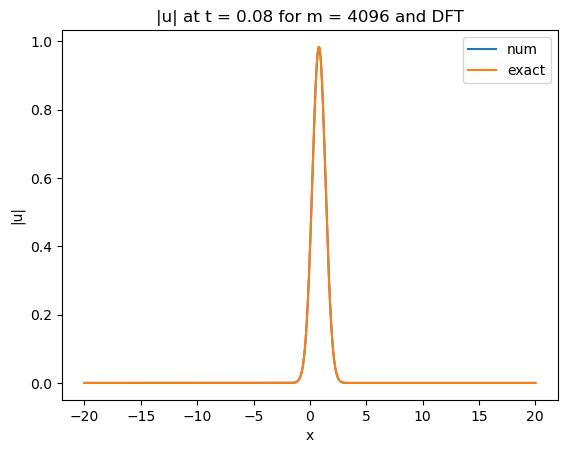

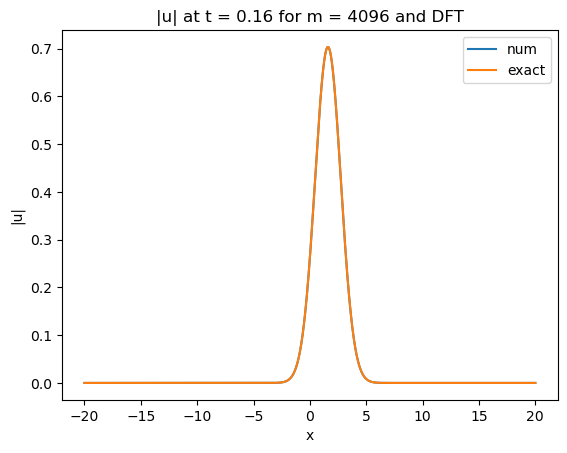

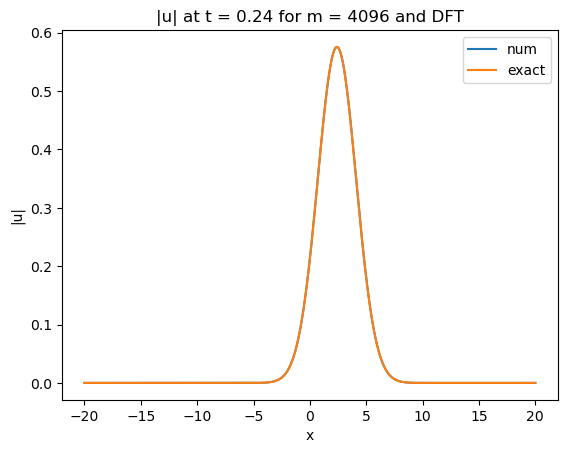

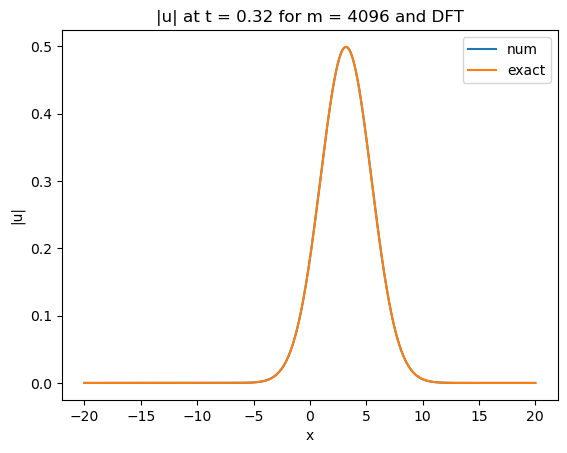

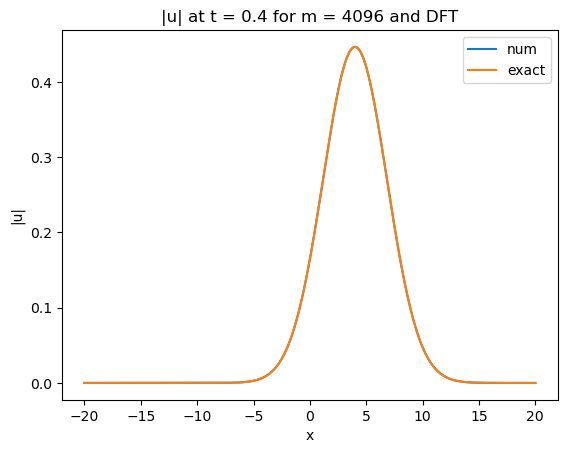

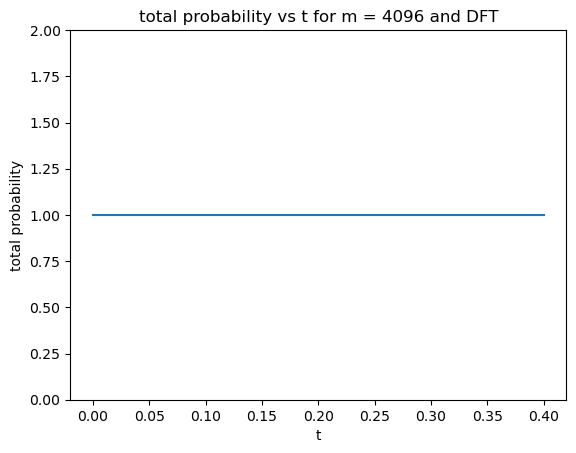

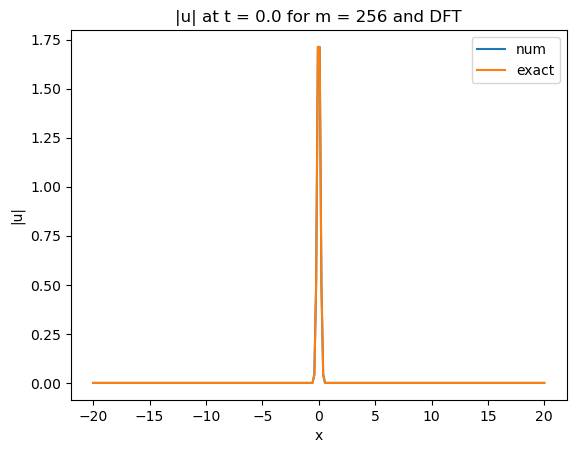

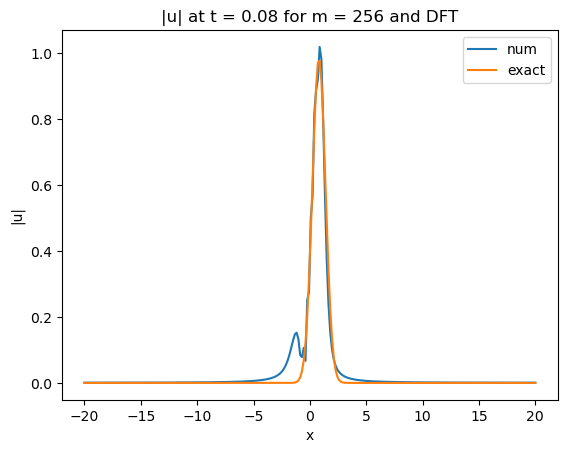

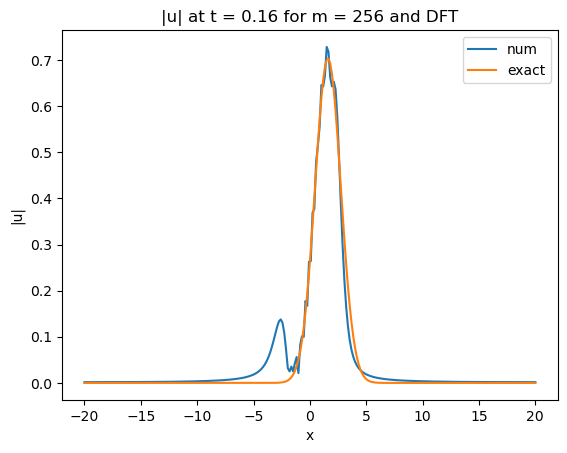

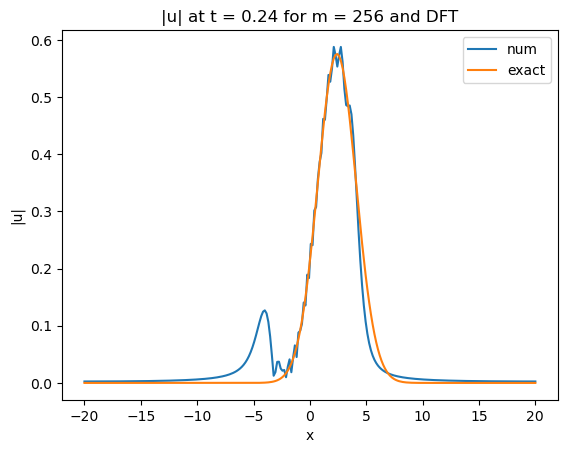

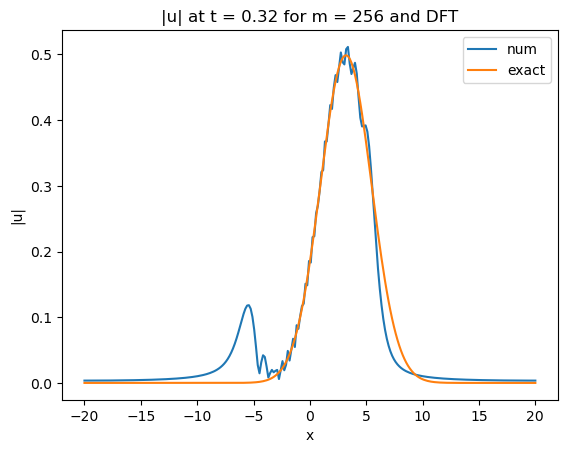

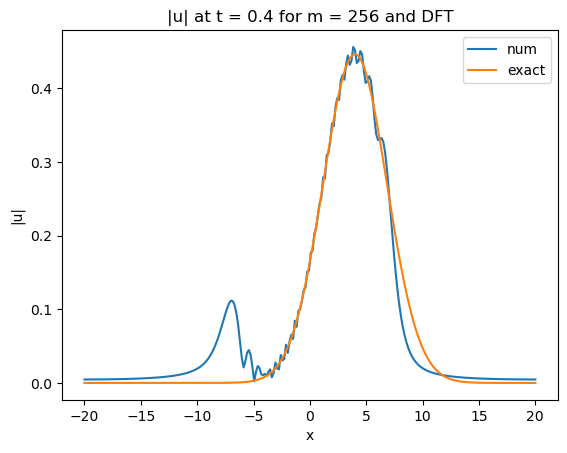

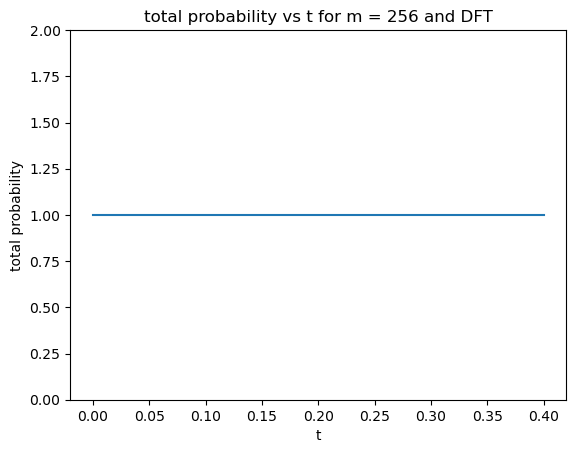

In [5]:
# parameters, mesh
k = 0.001
T = 0.4
N = int(T/k)
t_list = np.linspace(0,T,N+1)
xL = -20
xR = 20
for m in [4096,256]:
    h = (xR-xL)/(m-1)
    mesh = np.linspace(xL,xR,m)

    # solve PDE by DFT
    u0 = u0_func(mesh)
    u0hat = np.fft.fft(u0)
    u0hat_sep = np.concatenate((u0hat.real,u0hat.imag))
    xi = 2*np.pi*np.fft.fftfreq(m,d=h)
    uhat_sep = odeint(rhs,u0hat_sep,t_list,args=(xi,))
    uhat = uhat_sep[:,:m] + 1j*uhat_sep[:,m:]
    u = np.zeros_like(uhat)
    for j in range(N+1):
        u[j,:] = np.fft.ifft(uhat[j,:])

    # plot |u| at specific times
    u_abs = np.abs(u)
    t_plot = T/5*np.array(range(6))
    for j in range(N+1):
        t = j*k
        t = np.around(t,5)
        if np.around(t,5) in t_plot:
            plt.plot(mesh,u_abs[j],label='num')
            u_exact = [u_ex(x,t) for x in mesh]
            plt.plot(mesh,np.abs(u_exact),label='exact')
            plt.legend()
            plt.xlabel('x')
            plt.ylabel('|u|')
            plt.title('|u| at t = {} for m = {} and DFT'.format(t,m))
            plt.savefig('FINAL u_abs t = {} m = {} DFT.png'.format(t,m))
            plt.show()

    # plot total probability
    total_probs = np.trapz(u_abs**2,mesh)
    plt.plot(t_list,total_probs)
    plt.xlabel('t')
    plt.ylabel('total probability')
    plt.title('total probability vs t for m = {} and DFT'.format(m))
    ax = plt.gca()
    ax.set_ylim([0,2])
    plt.savefig('FINAL prob m = {} DFT.png'.format(m))
    plt.show()